## 1. 环境准备与数据加载

In [10]:
# ====================================================================
# 环境准备
# ====================================================================

# 数据处理库
import pandas as pd
import numpy as np
from datetime import datetime

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

print("✅ 所有库导入成功！")

✅ 所有库导入成功！


In [11]:
# ====================================================================
# 数据加载
# ====================================================================

import os

if os.path.exists('data_filtered.csv'):
    print("📖 读取预处理后的数据: data_filtered.csv ...")
    # 无表头格式，需要指定列名
    df = pd.read_csv('data_filtered.csv', header=None)
    df.columns = ['用户ID', '商品ID', '商品类目ID', '行为类型', '时间戳']
    print(f"   加载完成: {len(df):,} 行")
    
    # 转换时间戳为日期时间（UTC时间戳转换为北京时间 UTC+8）
    print("⏰ 转换时间戳为日期时间（UTC → 北京时间）...")
    df['时间'] = pd.to_datetime(df['时间戳'], unit='s') + pd.Timedelta(hours=8)
    df['日期'] = df['时间'].dt.date
    
    print("✅ 数据加载成功！")
    print(f"\n📊 数据概览:")
    print(f"   数据形状: {len(df):,} 行 × {df.shape[1]} 列")
    print(f"   时间范围: {df['日期'].min()} ~ {df['日期'].max()}")
    print(f"   用户数量: {df['用户ID'].nunique():,}")
    print(f"   商品数量: {df['商品ID'].nunique():,}")
    print(f"\n📋 行为类型分布:")
    print(df['行为类型'].value_counts())
else:
    print("⚠️ 未找到 data_filtered.csv")
    print("   请先在主分析文件中运行数据预处理生成该文件")
    raise FileNotFoundError("请先生成 data_filtered.csv 文件！")

📖 读取预处理后的数据: data_filtered.csv ...
   加载完成: 100,095,231 行
⏰ 转换时间戳为日期时间（UTC → 北京时间）...
   加载完成: 100,095,231 行
⏰ 转换时间戳为日期时间（UTC → 北京时间）...
✅ 数据加载成功！

📊 数据概览:
   数据形状: 100,095,231 行 × 7 列
✅ 数据加载成功！

📊 数据概览:
   数据形状: 100,095,231 行 × 7 列
   时间范围: 2017-11-25 ~ 2017-12-03
   时间范围: 2017-11-25 ~ 2017-12-03
   用户数量: 987,991
   用户数量: 987,991
   商品数量: 4,161,138

📋 行为类型分布:
行为类型
pv      89660688
cart     5530446
fav      2888258
buy      2015839
Name: count, dtype: int64
   商品数量: 4,161,138

📋 行为类型分布:
行为类型
pv      89660688
cart     5530446
fav      2888258
buy      2015839
Name: count, dtype: int64


## 1.5 数据分片（按用户分割）

将完整数据按用户ID平均分成10份，每份包含约10%的用户及其所有行为记录。

**优势：**
- 🚀 开发调试时只加载1份，速度提升10倍
- 👤 同一用户的所有行为保持在同一文件中，保证分析完整性
- 📊 最终可合并10份结果，得到完整分析

In [12]:
# ====================================================================
# 数据分片：按用户ID将数据平均分成10份
# ====================================================================

import os

# 分片目录
SHARD_DIR = 'user_shards'
NUM_SHARDS = 10

def create_user_shards(df, num_shards=10, output_dir='user_shards'):
    """
    按用户ID将数据分成多个分片
    同一用户的所有记录会在同一个分片中
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # 获取所有唯一用户ID
    unique_users = df['用户ID'].unique()
    total_users = len(unique_users)
    print(f"📊 总用户数: {total_users:,}")
    
    # 为每个用户分配分片编号（使用哈希确保一致性）
    user_to_shard = {user: hash(user) % num_shards for user in unique_users}
    
    # 添加分片列
    df['_shard'] = df['用户ID'].map(user_to_shard)
    
    # 分别保存每个分片
    shard_stats = []
    for shard_id in range(num_shards):
        shard_data = df[df['_shard'] == shard_id].drop(columns=['_shard'])
        shard_file = os.path.join(output_dir, f'shard_{shard_id:02d}.csv')
        
        # 保存（不含表头，与原格式一致）
        shard_data.to_csv(shard_file, index=False, header=False)
        
        shard_users = shard_data['用户ID'].nunique()
        shard_rows = len(shard_data)
        shard_stats.append({
            'shard': shard_id,
            'users': shard_users,
            'rows': shard_rows,
            'file': shard_file
        })
        print(f"   ✅ 分片 {shard_id:02d}: {shard_users:,} 用户, {shard_rows:,} 行 → {shard_file}")
    
    # 移除临时列
    df.drop(columns=['_shard'], inplace=True)
    
    return pd.DataFrame(shard_stats)

# 检查分片是否已存在
shard_files_exist = all(
    os.path.exists(os.path.join(SHARD_DIR, f'shard_{i:02d}.csv')) 
    for i in range(NUM_SHARDS)
)

if shard_files_exist:
    print("✅ 数据分片已存在，跳过分片步骤")
    print(f"   分片目录: {SHARD_DIR}/")
    for i in range(NUM_SHARDS):
        fpath = os.path.join(SHARD_DIR, f'shard_{i:02d}.csv')
        fsize = os.path.getsize(fpath) / (1024*1024)  # MB
        print(f"   • shard_{i:02d}.csv ({fsize:.1f} MB)")
else:
    print("🔧 开始创建数据分片...")
    print("=" * 60)
    
    # 需要原始数据（不含时间等衍生列）
    if '时间戳' in df.columns:
        df_to_shard = df[['用户ID', '商品ID', '商品类目ID', '行为类型', '时间戳']].copy()
    else:
        print("⚠️ 请先运行数据加载单元格")
        raise ValueError("数据未正确加载")
    
    shard_stats = create_user_shards(df_to_shard, NUM_SHARDS, SHARD_DIR)
    
    print("\n" + "=" * 60)
    print("📈 分片统计汇总:")
    print(shard_stats.to_string(index=False))
    print(f"\n✅ 数据分片完成！共 {NUM_SHARDS} 个分片")

🔧 开始创建数据分片...
📊 总用户数: 987,991
📊 总用户数: 987,991
   ✅ 分片 00: 98,767 用户, 9,980,307 行 → user_shards\shard_00.csv
   ✅ 分片 00: 98,767 用户, 9,980,307 行 → user_shards\shard_00.csv
   ✅ 分片 01: 98,759 用户, 9,989,997 行 → user_shards\shard_01.csv
   ✅ 分片 01: 98,759 用户, 9,989,997 行 → user_shards\shard_01.csv
   ✅ 分片 02: 98,798 用户, 9,991,150 行 → user_shards\shard_02.csv
   ✅ 分片 02: 98,798 用户, 9,991,150 行 → user_shards\shard_02.csv
   ✅ 分片 03: 98,855 用户, 10,001,952 行 → user_shards\shard_03.csv
   ✅ 分片 03: 98,855 用户, 10,001,952 行 → user_shards\shard_03.csv
   ✅ 分片 04: 98,819 用户, 10,023,955 行 → user_shards\shard_04.csv
   ✅ 分片 04: 98,819 用户, 10,023,955 行 → user_shards\shard_04.csv
   ✅ 分片 05: 98,817 用户, 10,000,097 行 → user_shards\shard_05.csv
   ✅ 分片 05: 98,817 用户, 10,000,097 行 → user_shards\shard_05.csv
   ✅ 分片 06: 98,748 用户, 9,990,759 行 → user_shards\shard_06.csv
   ✅ 分片 06: 98,748 用户, 9,990,759 行 → user_shards\shard_06.csv
   ✅ 分片 07: 98,837 用户, 10,054,308 行 → user_shards\shard_07.csv
   ✅ 分片 07: 98,83

## 1.6 加载单个分片进行分析

选择加载一个分片（约10%数据）进行快速分析和建模调试。

In [13]:
# ====================================================================
# 加载单个分片数据（快速模式）
# ====================================================================

# ⚙️ 配置：选择要加载的分片
SHARD_ID = 0  # 修改此值(0-9)来加载不同分片，或设为 'all' 加载全部

def load_shard(shard_id, shard_dir='user_shards'):
    """加载指定分片的数据"""
    shard_file = os.path.join(shard_dir, f'shard_{shard_id:02d}.csv')
    
    if not os.path.exists(shard_file):
        raise FileNotFoundError(f"分片文件不存在: {shard_file}")
    
    df = pd.read_csv(shard_file, header=None)
    df.columns = ['用户ID', '商品ID', '商品类目ID', '行为类型', '时间戳']
    
    # 转换时间
    df['时间'] = pd.to_datetime(df['时间戳'], unit='s') + pd.Timedelta(hours=8)
    df['日期'] = df['时间'].dt.date
    
    return df

def load_all_shards(shard_dir='user_shards', num_shards=10):
    """加载所有分片并合并"""
    dfs = []
    for i in range(num_shards):
        print(f"   加载分片 {i:02d}...")
        dfs.append(load_shard(i, shard_dir))
    return pd.concat(dfs, ignore_index=True)

# 根据配置加载数据
print("=" * 60)
if SHARD_ID == 'all':
    print("📖 加载全部分片数据...")
    df = load_all_shards(SHARD_DIR, NUM_SHARDS)
    print(f"\n✅ 已加载全部 {NUM_SHARDS} 个分片")
else:
    print(f"📖 加载分片 {SHARD_ID:02d} (快速模式，约10%数据)")
    df = load_shard(SHARD_ID, SHARD_DIR)
    print(f"\n✅ 已加载分片 {SHARD_ID:02d}")

print("=" * 60)
print(f"\n📊 当前数据概览:")
print(f"   数据量: {len(df):,} 行")
print(f"   用户数: {df['用户ID'].nunique():,}")
print(f"   商品数: {df['商品ID'].nunique():,}")
print(f"   时间范围: {df['日期'].min()} ~ {df['日期'].max()}")
print(f"\n📋 行为类型分布:")
print(df['行为类型'].value_counts())

# 重新提取购买记录（基于当前加载的数据）
buy_records = df[df['行为类型'] == 'buy'].copy()
print(f"\n🛒 购买记录: {len(buy_records):,} 条")

📖 加载分片 00 (快速模式，约10%数据)

✅ 已加载分片 00

📊 当前数据概览:
   数据量: 9,980,307 行
   用户数: 98,767

✅ 已加载分片 00

📊 当前数据概览:
   数据量: 9,980,307 行
   用户数: 98,767
   商品数: 1,588,705
   商品数: 1,588,705
   时间范围: 2017-11-25 ~ 2017-12-03

📋 行为类型分布:
行为类型
pv      8938121
cart     553595
fav      287593
buy      200998
Name: count, dtype: int64
   时间范围: 2017-11-25 ~ 2017-12-03

📋 行为类型分布:
行为类型
pv      8938121
cart     553595
fav      287593
buy      200998
Name: count, dtype: int64

🛒 购买记录: 200,998 条

🛒 购买记录: 200,998 条


## 2. 购买行为基础统计

In [23]:
# ====================================================================
# 购买行为基础统计
# ====================================================================

print("=" * 70)
print("🛒 购买行为基础统计")
print("=" * 70)

# 找出所有购买行为
buy_records = df[df['行为类型'] == 'buy'].copy()

print(f"\n📊 购买行为统计:")
print(f"   总购买次数: {len(buy_records):,}")
print(f"   购买用户数: {buy_records['用户ID'].nunique():,}")
print(f"   被购买商品数: {buy_records['商品ID'].nunique():,}")
print(f"   人均购买次数: {len(buy_records) / buy_records['用户ID'].nunique():.2f}")

# 用户购买次数分布
user_buy_counts = buy_records['用户ID'].value_counts()
print(f"\n📈 用户购买次数分布:")
print(f"   最多购买次数: {user_buy_counts.max()}")
print(f"   平均购买次数: {user_buy_counts.mean():.2f}")
print(f"   中位数购买次数: {user_buy_counts.median():.0f}")

🛒 购买行为基础统计

📊 购买行为统计:
   总购买次数: 200,998
   购买用户数: 67,421
   被购买商品数: 127,160
   人均购买次数: 2.98

📈 用户购买次数分布:
   最多购买次数: 177
   平均购买次数: 2.98
   中位数购买次数: 2


## 3. 单个购买案例追踪

In [24]:
# ====================================================================
# 用户购买前行为路径追踪（无时间窗口限制）
# ====================================================================

print("=" * 70)
print("🔍 用户购买前行为路径追踪")
print("=" * 70)

def trace_user_item_journey(user_id, item_id, buy_time, df):
    """
    追踪用户对特定商品在购买前的所有行为（无时间窗口限制）
    
    参数:
    - user_id: 用户ID
    - item_id: 商品ID  
    - buy_time: 购买时间
    - df: 完整数据集
    
    返回:
    - 该用户对该商品在购买前的所有行为序列
    """
    # 筛选该用户对该商品在购买前的所有行为
    user_item_behaviors = df[
        (df['用户ID'] == user_id) & 
        (df['商品ID'] == item_id) &
        (df['时间'] <= buy_time)
    ].sort_values('时间')
    
    return user_item_behaviors

# 随机抽取一些购买记录进行详细追踪展示
print("\n🎯 随机抽取5个购买案例，展示购买前完整行为路径")
print("-" * 70)

# 随机抽取5个购买记录
np.random.seed(42)
sample_buys = buy_records.sample(min(5, len(buy_records)))

for idx, (_, buy_row) in enumerate(sample_buys.iterrows(), 1):
    user_id = buy_row['用户ID']
    item_id = buy_row['商品ID']
    buy_time = buy_row['时间']
    
    print(f"\n{'─' * 70}")
    print(f"📦 案例 {idx}: 用户 {user_id} 购买商品 {item_id}")
    print(f"   购买时间: {buy_time}")
    print(f"{'─' * 70}")
    
    # 追踪购买前的所有行为（无时间限制）
    journey = trace_user_item_journey(user_id, item_id, buy_time, df)
    
    if len(journey) > 1:  # 除了购买本身还有其他行为
        first_contact = journey['时间'].min()
        time_span = buy_time - first_contact
        hours = time_span.total_seconds() / 3600
        
        print(f"   首次接触: {first_contact}")
        print(f"   决策时长: {hours:.2f} 小时 ({time_span})")
        print(f"\n   该用户对该商品的完整行为历程:")
        for _, row in journey.iterrows():
            behavior_icon = {'pv': '👁️ 浏览', 'cart': '🛒 加购', 'fav': '❤️ 收藏', 'buy': '💰 购买'}
            icon = behavior_icon.get(row['行为类型'], row['行为类型'])
            print(f"      {row['时间']} → {icon}")
    elif len(journey) == 1:
        print(f"   ⚠️ 无前序行为记录（直接购买 / 首次接触即购买）")
    else:
        print(f"   ⚠️ 数据异常")

print(f"\n{'=' * 70}")

🔍 用户购买前行为路径追踪

🎯 随机抽取5个购买案例，展示购买前完整行为路径
----------------------------------------------------------------------

──────────────────────────────────────────────────────────────────────
📦 案例 1: 用户 370900 购买商品 1250276
   购买时间: 2017-11-30 21:01:13
──────────────────────────────────────────────────────────────────────
   首次接触: 2017-11-30 20:40:04
   决策时长: 0.35 小时 (0 days 00:21:09)

   该用户对该商品的完整行为历程:
      2017-11-30 20:40:04 → 👁️ 浏览
      2017-11-30 21:01:13 → 💰 购买

──────────────────────────────────────────────────────────────────────
📦 案例 2: 用户 428160 购买商品 4636542
   购买时间: 2017-12-02 08:32:43
──────────────────────────────────────────────────────────────────────
   ⚠️ 无前序行为记录（直接购买 / 首次接触即购买）

──────────────────────────────────────────────────────────────────────
📦 案例 3: 用户 334000 购买商品 788629
   购买时间: 2017-11-29 14:56:36
──────────────────────────────────────────────────────────────────────
   首次接触: 2017-11-29 14:32:09
   决策时长: 0.41 小时 (0 days 00:24:27)

   该用户对该商品的完整行为历程:
      2017-11-29

## 4. 购买路径模式统计

In [25]:
# ====================================================================
# 购买路径模式统计分析（无时间窗口限制）
# ====================================================================

print("=" * 70)
print("📈 购买路径模式统计分析（无时间窗口限制）")
print("=" * 70)

# 优化策略：先构建用户-商品索引，避免重复遍历全表
print("⏳ 正在构建索引并分析购买路径模式...")

# 1. 抽样购买记录
sample_size = min(10000, len(buy_records))
np.random.seed(42)
buy_sample = buy_records.sample(sample_size)

# 2. 获取样本中涉及的用户和商品组合
sample_pairs = set(zip(buy_sample['用户ID'], buy_sample['商品ID']))
print(f"   样本购买记录数: {len(buy_sample):,}")
print(f"   涉及用户-商品组合: {len(sample_pairs):,}")

# 3. 只筛选相关的数据子集（大幅减少数据量）
relevant_users = buy_sample['用户ID'].unique()
relevant_items = buy_sample['商品ID'].unique()

print("   正在筛选相关数据...")
df_subset = df[df['用户ID'].isin(relevant_users) & df['商品ID'].isin(relevant_items)].copy()
print(f"   相关数据子集大小: {len(df_subset):,} 行")

# 4. 创建用户-商品分组索引
print("   正在构建分组索引...")
grouped = df_subset.groupby(['用户ID', '商品ID'])

# 5. 分析每个购买的前序行为（无时间窗口限制）
print("   正在分析购买路径（追溯全部历史行为）...")
paths = []
processed = 0
total = len(buy_sample)

for _, buy_row in buy_sample.iterrows():
    user_id = buy_row['用户ID']
    item_id = buy_row['商品ID']
    buy_time = buy_row['时间']
    
    try:
        # 获取该用户对该商品的所有行为
        user_item_data = grouped.get_group((user_id, item_id))
        
        # 筛选购买前的所有行为（无时间窗口限制）
        pre_buy = user_item_data[user_item_data['时间'] < buy_time].sort_values('时间')
        
        # 计算决策时长
        if len(pre_buy) > 0:
            first_contact = pre_buy['时间'].min()
            decision_hours = (buy_time - first_contact).total_seconds() / 3600
        else:
            decision_hours = 0
        
        # 生成路径
        if len(pre_buy) > 0:
            path = '→'.join(pre_buy['行为类型'].tolist()) + '→buy'
        else:
            path = 'direct_buy'
        
        # 统计行为
        behavior_counts = pre_buy['行为类型'].value_counts()
        
        paths.append({
            'user_id': user_id,
            'item_id': item_id,
            'path': path,
            'has_pv': 'pv' in behavior_counts.index,
            'has_cart': 'cart' in behavior_counts.index,
            'has_fav': 'fav' in behavior_counts.index,
            'pv_count': behavior_counts.get('pv', 0),
            'cart_count': behavior_counts.get('cart', 0),
            'fav_count': behavior_counts.get('fav', 0),
            'total_pre_actions': len(pre_buy),
            'decision_hours': decision_hours
        })
    except KeyError:
        # 该组合不存在于子集中
        paths.append({
            'user_id': user_id,
            'item_id': item_id,
            'path': 'direct_buy',
            'has_pv': False,
            'has_cart': False,
            'has_fav': False,
            'pv_count': 0,
            'cart_count': 0,
            'fav_count': 0,
            'total_pre_actions': 0,
            'decision_hours': 0
        })
    
    processed += 1
    if processed % 2000 == 0:
        print(f"   已处理: {processed:,}/{total:,} ({processed/total*100:.1f}%)")

path_df = pd.DataFrame(paths)
print(f"\n✅ 分析完成！共分析 {len(path_df):,} 条购买记录")

# 统计购买前是否有各类行为
print("\n" + "=" * 70)
print("📊 购买前行为组合统计（追溯全部历史，无时间窗口限制）")
print("=" * 70)

# 行为组合统计
path_df['behavior_combo'] = path_df.apply(
    lambda x: f"{'pv' if x['has_pv'] else ''}"
              f"{'+cart' if x['has_cart'] else ''}"
              f"{'+fav' if x['has_fav'] else ''}"
              if any([x['has_pv'], x['has_cart'], x['has_fav']]) else 'direct',
    axis=1
)

combo_stats = path_df['behavior_combo'].value_counts()
combo_pct = (combo_stats / len(path_df) * 100).round(2)

print("\n行为组合分布:")
for combo, count in combo_stats.items():
    pct = combo_pct[combo]
    bar = '█' * int(pct / 2)
    print(f"   {combo:20s}: {count:6,} ({pct:5.2f}%) {bar}")

# 直接购买 vs 有前序行为购买
direct_buy_pct = (path_df['total_pre_actions'] == 0).sum() / len(path_df) * 100
pre_action_buy_pct = 100 - direct_buy_pct

print(f"\n📌 关键发现:")
print(f"   • 直接购买（无前序行为）: {direct_buy_pct:.2f}%")
print(f"   • 有前序行为的购买: {pre_action_buy_pct:.2f}%")

# 有前序行为的购买决策时长统计
pre_action_df = path_df[path_df['total_pre_actions'] > 0]
if len(pre_action_df) > 0:
    print(f"\n⏱️ 决策时长统计（有前序行为的购买）:")
    print(f"   • 平均决策时长: {pre_action_df['decision_hours'].mean():.2f} 小时")
    print(f"   • 中位数决策时长: {pre_action_df['decision_hours'].median():.2f} 小时")
    print(f"   • 最长决策时长: {pre_action_df['decision_hours'].max():.2f} 小时（{pre_action_df['decision_hours'].max()/24:.1f} 天）")

📈 购买路径模式统计分析（无时间窗口限制）
⏳ 正在构建索引并分析购买路径模式...
   样本购买记录数: 10,000
   涉及用户-商品组合: 9,974
   正在筛选相关数据...
   样本购买记录数: 10,000
   涉及用户-商品组合: 9,974
   正在筛选相关数据...
   相关数据子集大小: 86,203 行
   正在构建分组索引...
   正在分析购买路径（追溯全部历史行为）...
   相关数据子集大小: 86,203 行
   正在构建分组索引...
   正在分析购买路径（追溯全部历史行为）...
   已处理: 2,000/10,000 (20.0%)
   已处理: 2,000/10,000 (20.0%)
   已处理: 4,000/10,000 (40.0%)
   已处理: 4,000/10,000 (40.0%)
   已处理: 6,000/10,000 (60.0%)
   已处理: 6,000/10,000 (60.0%)
   已处理: 8,000/10,000 (80.0%)
   已处理: 8,000/10,000 (80.0%)
   已处理: 10,000/10,000 (100.0%)

✅ 分析完成！共分析 10,000 条购买记录

📊 购买前行为组合统计（追溯全部历史，无时间窗口限制）

行为组合分布:
   direct              :  3,943 (39.43%) ███████████████████
   pv                  :  3,796 (37.96%) ██████████████████
   pv+cart             :  1,007 (10.07%) █████
   +cart               :    609 ( 6.09%) ███
   pv+fav              :    365 ( 3.65%) █
   +fav                :    205 ( 2.05%) █
   pv+cart+fav         :     61 ( 0.61%) 
   +cart+fav           :     14 ( 0.14%) 

📌 关键发现:
   • 直接

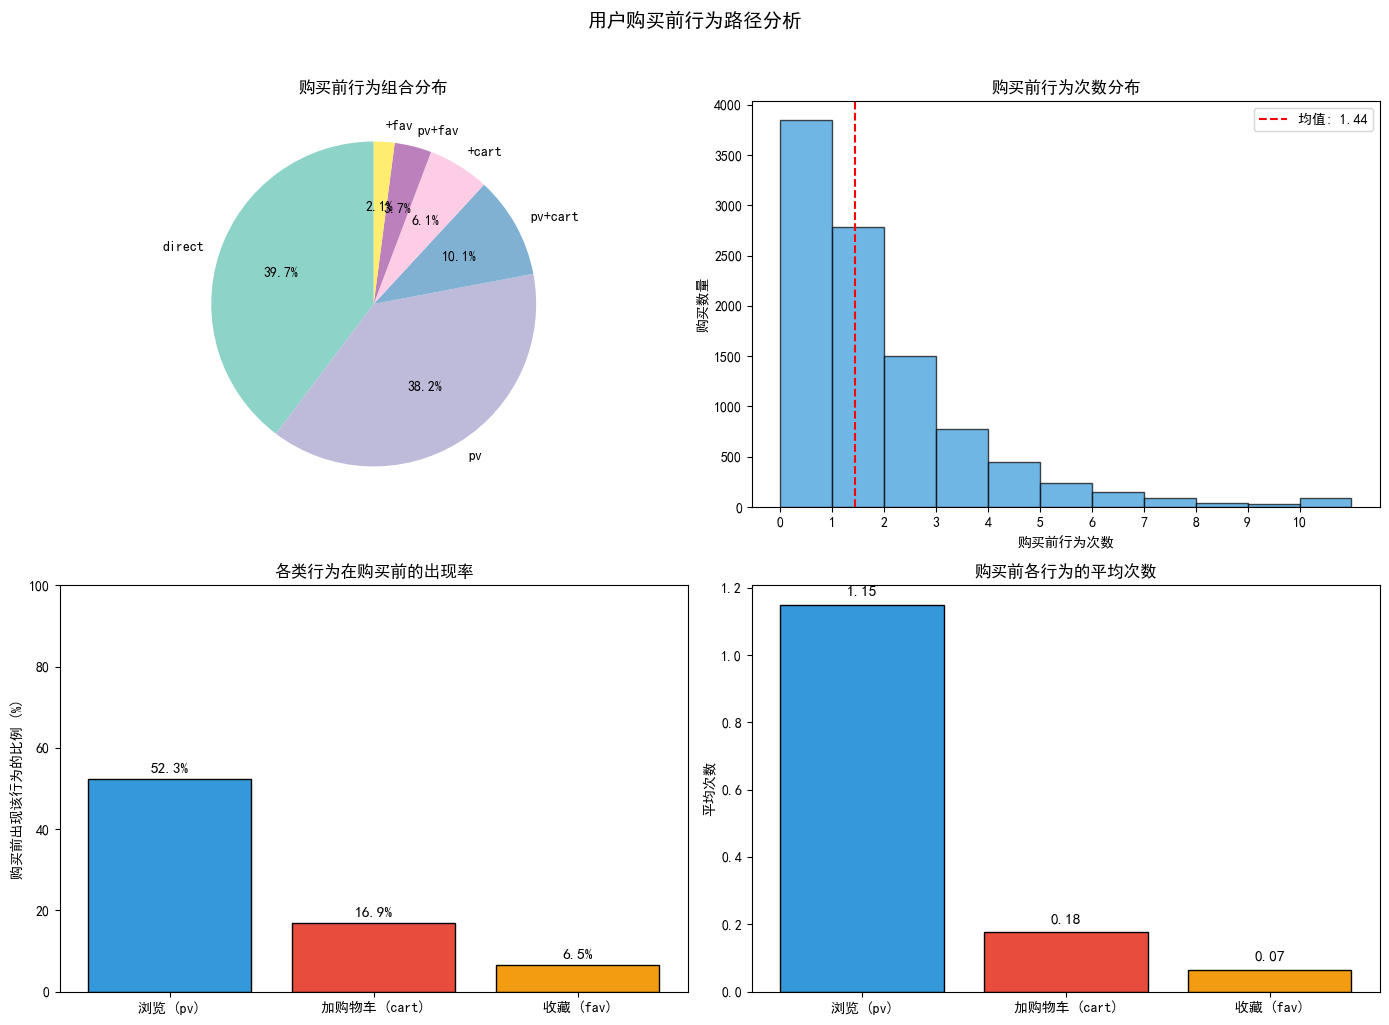


💡 分析洞察:
   • 平均每次购买前有 1.44 次前序行为
   • 52.3% 的购买在之前浏览过该商品
   • 16.9% 的购买在之前加入过购物车
   • 6.5% 的购买在之前收藏过该商品


In [26]:
# ====================================================================
# 可视化：购买前行为模式
# ====================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 行为组合饼图
ax1 = axes[0, 0]
combo_top = combo_stats.head(6)
colors = plt.cm.Set3(np.linspace(0, 1, len(combo_top)))
wedges, texts, autotexts = ax1.pie(combo_top.values, labels=combo_top.index, 
                                    autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('购买前行为组合分布', fontsize=12, fontweight='bold')

# 2. 购买前行为次数分布
ax2 = axes[0, 1]
action_counts = path_df['total_pre_actions'].clip(upper=10)  # 限制最大值便于展示
ax2.hist(action_counts, bins=range(0, 12), edgecolor='black', alpha=0.7, color='#3498db')
ax2.set_xlabel('购买前行为次数')
ax2.set_ylabel('购买数量')
ax2.set_title('购买前行为次数分布', fontsize=12, fontweight='bold')
ax2.set_xticks(range(0, 11))
ax2.axvline(x=path_df['total_pre_actions'].mean(), color='red', linestyle='--', 
            label=f'均值: {path_df["total_pre_actions"].mean():.2f}')
ax2.legend()

# 3. 各类行为在购买前的出现率
ax3 = axes[1, 0]
behavior_presence = {
    '浏览 (pv)': path_df['has_pv'].mean() * 100,
    '加购物车 (cart)': path_df['has_cart'].mean() * 100,
    '收藏 (fav)': path_df['has_fav'].mean() * 100,
}
bars = ax3.bar(behavior_presence.keys(), behavior_presence.values(), 
               color=['#3498db', '#e74c3c', '#f39c12'], edgecolor='black')
ax3.set_ylabel('购买前出现该行为的比例 (%)')
ax3.set_title('各类行为在购买前的出现率', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 100)
for bar, val in zip(bars, behavior_presence.values()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. 购买前各行为的平均次数
ax4 = axes[1, 1]
avg_behaviors = {
    '浏览 (pv)': path_df['pv_count'].mean(),
    '加购物车 (cart)': path_df['cart_count'].mean(),
    '收藏 (fav)': path_df['fav_count'].mean(),
}
bars = ax4.bar(avg_behaviors.keys(), avg_behaviors.values(), 
               color=['#3498db', '#e74c3c', '#f39c12'], edgecolor='black')
ax4.set_ylabel('平均次数')
ax4.set_title('购买前各行为的平均次数', fontsize=12, fontweight='bold')
for bar, val in zip(bars, avg_behaviors.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('用户购买前行为路径分析', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 分析洞察:")
print(f"   • 平均每次购买前有 {path_df['total_pre_actions'].mean():.2f} 次前序行为")
print(f"   • {behavior_presence['浏览 (pv)']:.1f}% 的购买在之前浏览过该商品")
print(f"   • {behavior_presence['加购物车 (cart)']:.1f}% 的购买在之前加入过购物车")
print(f"   • {behavior_presence['收藏 (fav)']:.1f}% 的购买在之前收藏过该商品")

## 5. 典型购买路径序列

🎯 典型购买路径模式分析

📋 最常见的15种购买路径:
----------------------------------------------------------------------
    1. direct_购买                                          3,845 (38.45%)
    2. 浏览→购买                                              1,919 (19.19%)
    3. 浏览→浏览→购买                                             902 ( 9.02%)
    4. 加购→购买                                                578 ( 5.78%)
    5. 浏览→浏览→浏览→购买                                          363 ( 3.63%)
    6. 加购→浏览→购买                                             267 ( 2.67%)
    7. 收藏→购买                                                196 ( 1.96%)
    8. 浏览→浏览→浏览→浏览→购买                                       193 ( 1.93%)
    9. 加购→浏览→浏览→购买                                          158 ( 1.58%)
   10. 收藏→浏览→购买                                              98 ( 0.98%)
   11. 浏览→浏览→浏览→浏览→浏览→购买                                     91 ( 0.91%)
   12. 购买→购买                                                 91 ( 0.91%)
   13. 加购→浏览→浏览→浏览→购买   

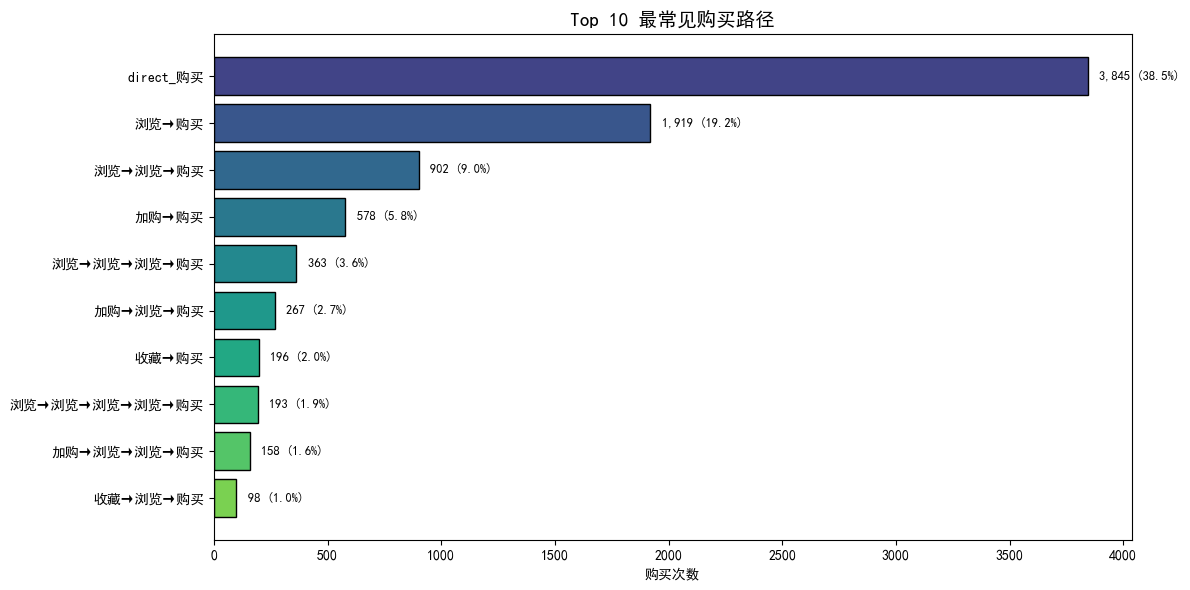

In [27]:
# ====================================================================
# 典型用户购买旅程深度分析
# ====================================================================

print("=" * 70)
print("🎯 典型购买路径模式分析")
print("=" * 70)

# 统计最常见的购买路径序列
path_counts = path_df['path'].value_counts().head(15)

print("\n📋 最常见的15种购买路径:")
print("-" * 70)
for i, (path, count) in enumerate(path_counts.items(), 1):
    pct = count / len(path_df) * 100
    # 美化路径显示
    path_display = path.replace('pv', '浏览').replace('cart', '加购').replace('fav', '收藏').replace('buy', '购买').replace('direct_buy', '直接购买')
    print(f"   {i:2d}. {path_display:50s} {count:5,} ({pct:5.2f}%)")

# 可视化top购买路径
fig, ax = plt.subplots(figsize=(12, 6))
top_paths = path_counts.head(10)

# 美化标签
labels = [p.replace('pv', '浏览').replace('cart', '加购').replace('fav', '收藏').replace('buy', '购买').replace('direct_buy', '直接购买') 
          for p in top_paths.index]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_paths)))
bars = ax.barh(range(len(top_paths)), top_paths.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(top_paths)))
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('购买次数')
ax.set_title('Top 10 最常见购买路径', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for bar, val in zip(bars, top_paths.values):
    pct = val / len(path_df) * 100
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
            f'{val:,} ({pct:.1f}%)', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. 单个用户完整行为历程

👤 单个用户完整行为历程追踪

🔍 选中用户: 424280
   该用户总行为数: 381
   行为类型分布:
      • pv: 353
      • fav: 11
      • cart: 9
      • buy: 8

   购买记录数: 8

──────────────────────────────────────────────────────────────────────
   该用户各商品的购买旅程:
──────────────────────────────────────────────────────────────────────

   📦 商品 1736298:
      2017-11-29 22:04:46 👁️ 浏览 
      2017-11-29 23:29:05 👁️ 浏览 
      2017-11-30 10:06:50 👁️ 浏览 
      2017-11-30 11:21:46 👁️ 浏览 
      2017-11-30 15:22:50 🛒 加购 
      2017-11-30 15:31:31 👁️ 浏览 
      2017-11-30 18:15:33 👁️ 浏览 
      2017-11-30 19:39:50 💰 购买 ← 成交!
      2017-11-30 19:45:10 👁️ 浏览 
      2017-11-30 20:49:19 👁️ 浏览 

   📦 商品 539095:
      2017-11-29 22:06:53 👁️ 浏览 
      2017-11-29 23:21:47 👁️ 浏览 
      2017-11-30 18:50:59 👁️ 浏览 
      2017-11-30 18:57:57 👁️ 浏览 
      2017-12-01 19:45:27 💰 购买 ← 成交!
      2017-12-01 19:47:35 👁️ 浏览 
      2017-12-01 20:01:53 👁️ 浏览 
      2017-12-01 20:02:42 👁️ 浏览 
      2017-12-01 20:04:09 👁️ 浏览 
      2017-12-03 11:00:47 👁️ 浏览 
     

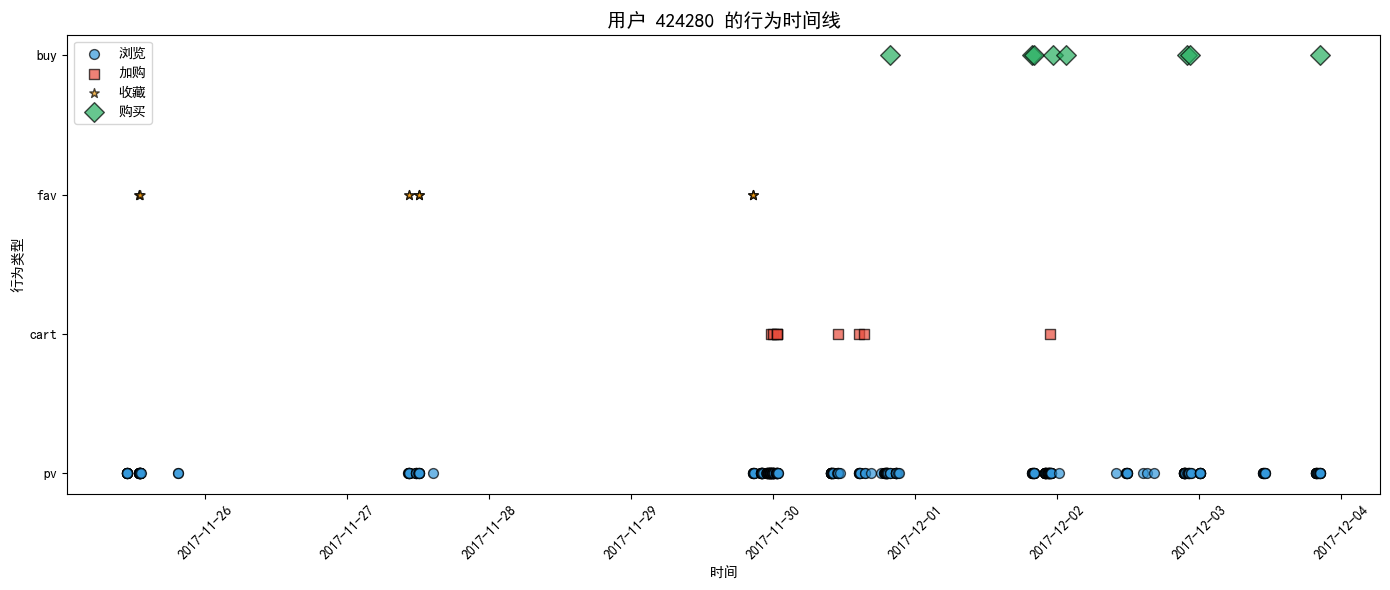

In [28]:
# ====================================================================
# 单个用户完整行为历程可视化
# ====================================================================

print("=" * 70)
print("👤 单个用户完整行为历程追踪")
print("=" * 70)

# 找一个有丰富行为的用户进行深度展示
# 选择购买次数较多且行为丰富的用户
user_buy_counts = buy_records['用户ID'].value_counts()
# 选择购买次数在5-20次之间的用户（行为较丰富）
candidate_users = user_buy_counts[(user_buy_counts >= 5) & (user_buy_counts <= 20)].index.tolist()

if len(candidate_users) > 0:
    # 随机选择一个用户
    np.random.seed(123)
    selected_user = np.random.choice(candidate_users)
    
    print(f"\n🔍 选中用户: {selected_user}")
    
    # 获取该用户的所有行为
    user_behaviors = df[df['用户ID'] == selected_user].sort_values('时间').copy()
    
    print(f"   该用户总行为数: {len(user_behaviors):,}")
    print(f"   行为类型分布:")
    for bt, count in user_behaviors['行为类型'].value_counts().items():
        print(f"      • {bt}: {count}")
    
    # 获取该用户购买的商品
    user_buys = user_behaviors[user_behaviors['行为类型'] == 'buy']
    print(f"\n   购买记录数: {len(user_buys)}")
    
    # 为每个购买的商品追踪行为路径
    print(f"\n{'─' * 70}")
    print(f"   该用户各商品的购买旅程:")
    print(f"{'─' * 70}")
    
    for idx, (_, buy_row) in enumerate(user_buys.head(5).iterrows(), 1):  # 最多展示5个
        item_id = buy_row['商品ID']
        buy_time = buy_row['时间']
        
        # 该用户对该商品的所有行为
        item_journey = user_behaviors[user_behaviors['商品ID'] == item_id].sort_values('时间')
        
        print(f"\n   📦 商品 {item_id}:")
        for _, row in item_journey.iterrows():
            behavior_icon = {'pv': '👁️', 'cart': '🛒', 'fav': '❤️', 'buy': '💰'}
            behavior_name = {'pv': '浏览', 'cart': '加购', 'fav': '收藏', 'buy': '购买'}
            icon = behavior_icon.get(row['行为类型'], '•')
            name = behavior_name.get(row['行为类型'], row['行为类型'])
            is_buy = '← 成交!' if row['行为类型'] == 'buy' else ''
            print(f"      {row['时间']} {icon} {name} {is_buy}")

    # 可视化该用户的行为时间线
    fig, ax = plt.subplots(figsize=(14, 6))
    
    behavior_colors = {'pv': '#3498db', 'cart': '#e74c3c', 'fav': '#f39c12', 'buy': '#27ae60'}
    behavior_markers = {'pv': 'o', 'cart': 's', 'fav': '*', 'buy': 'D'}
    behavior_names = {'pv': '浏览', 'cart': '加购', 'fav': '收藏', 'buy': '购买'}
    
    for behavior in ['pv', 'cart', 'fav', 'buy']:
        behavior_data = user_behaviors[user_behaviors['行为类型'] == behavior]
        if len(behavior_data) > 0:
            ax.scatter(behavior_data['时间'], [behavior] * len(behavior_data),
                      c=behavior_colors[behavior], marker=behavior_markers[behavior],
                      s=100 if behavior == 'buy' else 50, label=behavior_names[behavior],
                      alpha=0.7, edgecolors='black')
    
    ax.set_xlabel('时间')
    ax.set_ylabel('行为类型')
    ax.set_title(f'用户 {selected_user} 的行为时间线', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 未找到符合条件的用户")

## 7. 购买决策时间分析

⏱️ 购买决策时间分析
⏳ 正在计算购买决策时间...
   已处理: 2,000/10,000 (20.0%)
   已处理: 2,000/10,000 (20.0%)
   已处理: 4,000/10,000 (40.0%)
   已处理: 4,000/10,000 (40.0%)
   已处理: 6,000/10,000 (60.0%)
   已处理: 6,000/10,000 (60.0%)
   已处理: 8,000/10,000 (80.0%)
   已处理: 8,000/10,000 (80.0%)
   已处理: 10,000/10,000 (100.0%)

✅ 分析完成！共 6,155 条有前序行为的购买记录

📊 决策时间统计 (从首次接触到购买):
   • 平均决策时间: 19.96 小时 (1197.5 分钟)
   • 中位数决策时间: 1.75 小时 (104.9 分钟)
   • 最短决策时间: 0.12 分钟
   • 最长决策时间: 204.07 小时

🔬 短时决策深度分析（1小时内）

1小时内完成决策的购买: 2,851 (46.3%)

⏰ 1小时内决策时间细分:
   <1分钟        :    67 (  2.4% of 短决策 |   1.1% of 全部) 
   1-5分钟       :   638 ( 22.4% of 短决策 |  10.4% of 全部) ███████
   5-10分钟      :   681 ( 23.9% of 短决策 |  11.1% of 全部) ███████
   10-15分钟     :   431 ( 15.1% of 短决策 |   7.0% of 全部) █████
   15-30分钟     :   607 ( 21.3% of 短决策 |   9.9% of 全部) ███████
   30-60分钟     :   427 ( 15.0% of 短决策 |   6.9% of 全部) ████
   已处理: 10,000/10,000 (100.0%)

✅ 分析完成！共 6,155 条有前序行为的购买记录

📊 决策时间统计 (从首次接触到购买):
   • 平均决策时间: 19.96 小时 (1197.5 分钟)
   • 中位数决策时间

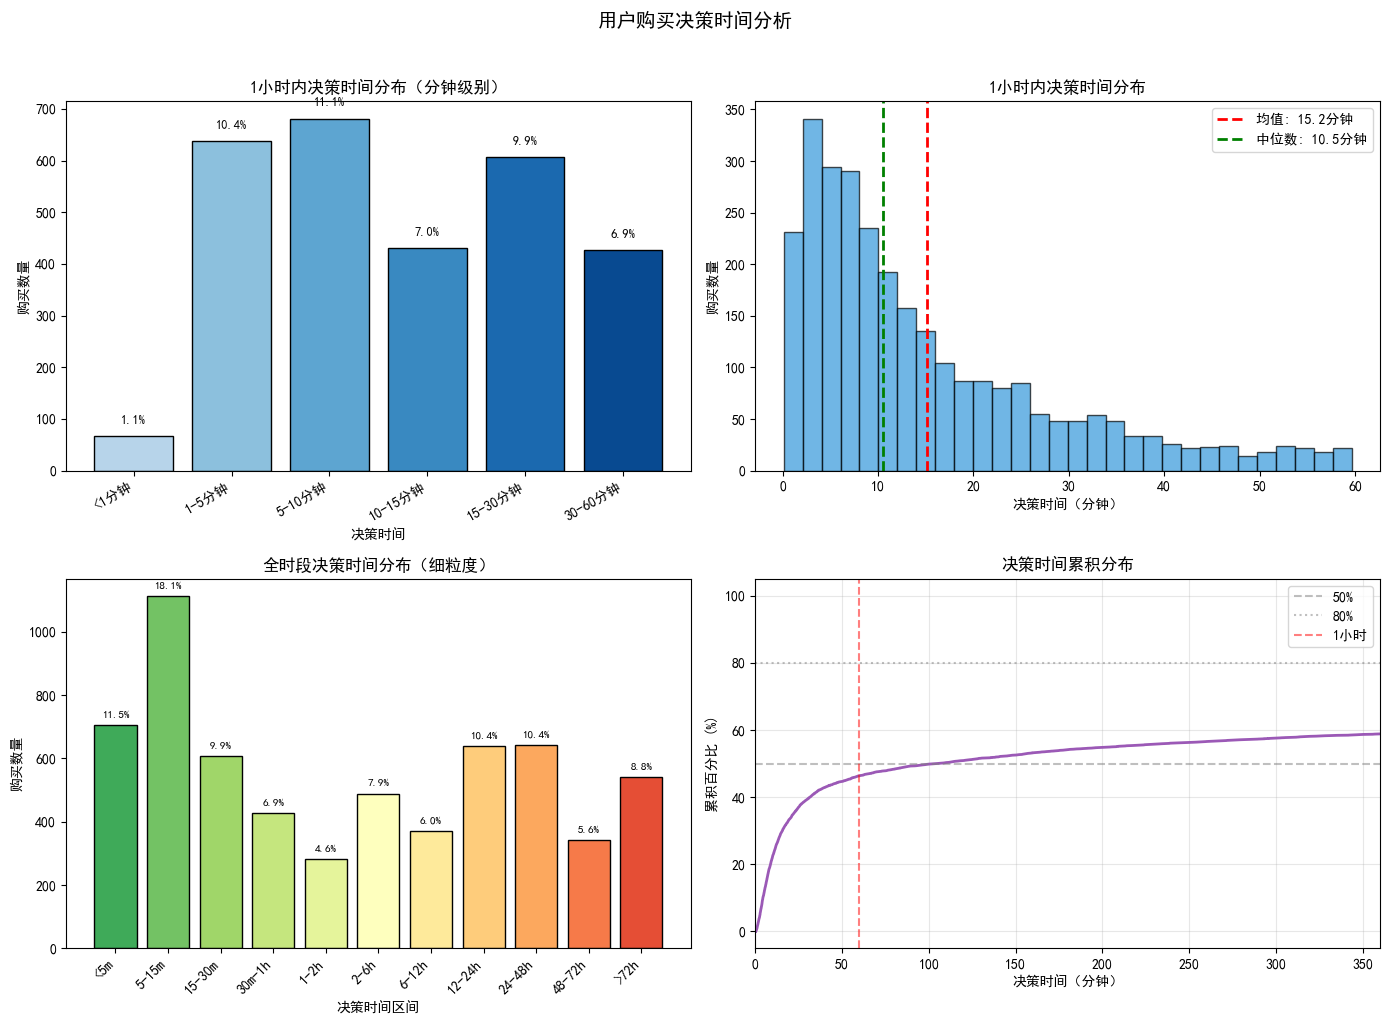


💡 关键洞察

📊 购买决策速度分类:
   • 即时决策（≤5分钟）:    11.5%  ⚡ 冲动型购买
   • 快速决策（5-30分钟）:  27.9%  🚀 快速比较后购买
   • 短期决策（30分-1小时）:  6.9%  ⏱️ 短暂考虑
   • 中期决策（1-24小时）:  28.9%  🤔 需要时间考虑
   • 长期决策（>24小时）:   24.8%  📅 深思熟虑型

📈 决策时间分位数:
   • 50%的用户在 104.9 分钟内完成决策
   • 80%的用户在 1911.2 分钟内完成决策
   • 95%的用户在 6096.6 分钟（101.6小时）内完成决策


In [29]:
# ====================================================================
# 购买决策时间分析（优化版 - 复用之前的分组索引）
# ====================================================================

print("=" * 70)
print("⏱️ 购买决策时间分析")
print("=" * 70)

# 复用之前构建的 grouped 索引，快速计算决策时间
print("⏳ 正在计算购买决策时间...")

decision_times = []
processed = 0
total = len(buy_sample)

for _, buy_row in buy_sample.iterrows():
    user_id = buy_row['用户ID']
    item_id = buy_row['商品ID']
    buy_time = buy_row['时间']
    
    try:
        # 使用之前的分组索引
        user_item_data = grouped.get_group((user_id, item_id))
        
        # 找到购买前的最早接触时间
        first_contact = user_item_data[user_item_data['时间'] < buy_time]['时间'].min()
        
        if pd.notna(first_contact):
            time_diff = (buy_time - first_contact).total_seconds() / 3600
            decision_times.append({
                'user_id': user_id,
                'item_id': item_id,
                'first_contact': first_contact,
                'buy_time': buy_time,
                'decision_hours': time_diff,
                'decision_minutes': time_diff * 60  # 同时记录分钟
            })
    except KeyError:
        pass
    
    processed += 1
    if processed % 2000 == 0:
        print(f"   已处理: {processed:,}/{total:,} ({processed/total*100:.1f}%)")

decision_df = pd.DataFrame(decision_times)

if len(decision_df) > 0:
    print(f"\n✅ 分析完成！共 {len(decision_df):,} 条有前序行为的购买记录")
    
    # 统计
    print(f"\n📊 决策时间统计 (从首次接触到购买):")
    print(f"   • 平均决策时间: {decision_df['decision_hours'].mean():.2f} 小时 ({decision_df['decision_minutes'].mean():.1f} 分钟)")
    print(f"   • 中位数决策时间: {decision_df['decision_hours'].median():.2f} 小时 ({decision_df['decision_minutes'].median():.1f} 分钟)")
    print(f"   • 最短决策时间: {decision_df['decision_minutes'].min():.2f} 分钟")
    print(f"   • 最长决策时间: {decision_df['decision_hours'].max():.2f} 小时")
    
    # ========== 细粒度分析：1小时内的决策时间 ==========
    print("\n" + "=" * 70)
    print("🔬 短时决策深度分析（1小时内）")
    print("=" * 70)
    
    short_term = decision_df[decision_df['decision_hours'] <= 1]
    print(f"\n1小时内完成决策的购买: {len(short_term):,} ({len(short_term)/len(decision_df)*100:.1f}%)")
    
    # 细粒度分段（分钟级别）
    minute_bins = [0, 1, 5, 10, 15, 30, 60]
    minute_labels = ['<1分钟', '1-5分钟', '5-10分钟', '10-15分钟', '15-30分钟', '30-60分钟']
    short_term_copy = short_term.copy()
    short_term_copy['minute_bucket'] = pd.cut(short_term_copy['decision_minutes'], bins=minute_bins, labels=minute_labels)
    minute_counts = short_term_copy['minute_bucket'].value_counts().reindex(minute_labels).fillna(0)
    
    print("\n⏰ 1小时内决策时间细分:")
    for label, count in minute_counts.items():
        pct_of_short = count / len(short_term) * 100 if len(short_term) > 0 else 0
        pct_of_all = count / len(decision_df) * 100
        bar = '█' * int(pct_of_short / 3)
        print(f"   {label:12s}: {int(count):5,} ({pct_of_short:5.1f}% of 短决策 | {pct_of_all:5.1f}% of 全部) {bar}")
    
    # ========== 可视化 ==========
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 1小时内细粒度分布（分钟级别）
    ax1 = axes[0, 0]
    colors_minute = plt.cm.Blues(np.linspace(0.3, 0.9, len(minute_labels)))
    bars1 = ax1.bar(minute_labels, minute_counts.values, color=colors_minute, edgecolor='black')
    ax1.set_xlabel('决策时间')
    ax1.set_ylabel('购买数量')
    ax1.set_title('1小时内决策时间分布（分钟级别）', fontsize=12, fontweight='bold')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')
    for bar, val in zip(bars1, minute_counts.values):
        if val > 0:
            pct = val / len(decision_df) * 100
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. 1小时内决策时间直方图（更细的bins）
    ax2 = axes[0, 1]
    if len(short_term) > 0:
        ax2.hist(short_term['decision_minutes'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
        ax2.axvline(x=short_term['decision_minutes'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'均值: {short_term["decision_minutes"].mean():.1f}分钟')
        ax2.axvline(x=short_term['decision_minutes'].median(), color='green', linestyle='--', linewidth=2, 
                    label=f'中位数: {short_term["decision_minutes"].median():.1f}分钟')
    ax2.set_xlabel('决策时间（分钟）')
    ax2.set_ylabel('购买数量')
    ax2.set_title('1小时内决策时间分布', fontsize=12, fontweight='bold')
    ax2.legend()
    
    # 3. 全时段分布（小时级别，更细的划分）
    ax3 = axes[1, 0]
    hour_bins = [0, 0.0833, 0.25, 0.5, 1, 2, 6, 12, 24, 48, 72, float('inf')]  # 5分钟, 15分钟, 30分钟, 1小时...
    hour_labels = ['<5m', '5-15m', '15-30m', '30m-1h', '1-2h', '2-6h', '6-12h', '12-24h', '24-48h', '48-72h', '>72h']
    decision_df['hour_bucket'] = pd.cut(decision_df['decision_hours'], bins=hour_bins, labels=hour_labels)
    hour_counts = decision_df['hour_bucket'].value_counts().reindex(hour_labels).fillna(0)
    
    colors_hour = plt.cm.RdYlGn(np.linspace(0.85, 0.15, len(hour_labels)))
    bars3 = ax3.bar(hour_labels, hour_counts.values, color=colors_hour, edgecolor='black')
    ax3.set_xlabel('决策时间区间')
    ax3.set_ylabel('购买数量')
    ax3.set_title('全时段决策时间分布（细粒度）', fontsize=12, fontweight='bold')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    for bar, val in zip(bars3, hour_counts.values):
        if val > 0:
            pct = val / len(decision_df) * 100
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # 4. 累积分布图
    ax4 = axes[1, 1]
    sorted_times = np.sort(decision_df['decision_minutes'].values)
    cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times) * 100
    ax4.plot(sorted_times, cumulative, color='#9b59b6', linewidth=2)
    ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50%')
    ax4.axhline(y=80, color='gray', linestyle=':', alpha=0.5, label='80%')
    ax4.axvline(x=60, color='red', linestyle='--', alpha=0.5, label='1小时')
    ax4.set_xlabel('决策时间（分钟）')
    ax4.set_ylabel('累积百分比 (%)')
    ax4.set_title('决策时间累积分布', fontsize=12, fontweight='bold')
    ax4.set_xlim(0, 360)  # 限制在6小时内
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('用户购买决策时间分析', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ========== 关键洞察 ==========
    print("\n" + "=" * 70)
    print("💡 关键洞察")
    print("=" * 70)
    
    # 细粒度分类
    instant_pct = (decision_df['decision_minutes'] <= 5).sum() / len(decision_df) * 100
    quick_pct = ((decision_df['decision_minutes'] > 5) & (decision_df['decision_minutes'] <= 30)).sum() / len(decision_df) * 100
    short_pct = ((decision_df['decision_minutes'] > 30) & (decision_df['decision_hours'] <= 1)).sum() / len(decision_df) * 100
    medium_pct = ((decision_df['decision_hours'] > 1) & (decision_df['decision_hours'] <= 24)).sum() / len(decision_df) * 100
    long_pct = (decision_df['decision_hours'] > 24).sum() / len(decision_df) * 100
    
    print(f"\n📊 购买决策速度分类:")
    print(f"   • 即时决策（≤5分钟）:   {instant_pct:5.1f}%  ⚡ 冲动型购买")
    print(f"   • 快速决策（5-30分钟）: {quick_pct:5.1f}%  🚀 快速比较后购买")
    print(f"   • 短期决策（30分-1小时）:{short_pct:5.1f}%  ⏱️ 短暂考虑")
    print(f"   • 中期决策（1-24小时）: {medium_pct:5.1f}%  🤔 需要时间考虑")
    print(f"   • 长期决策（>24小时）:  {long_pct:5.1f}%  📅 深思熟虑型")
    
    # 计算关键分位数
    p50 = decision_df['decision_minutes'].quantile(0.5)
    p80 = decision_df['decision_minutes'].quantile(0.8)
    p95 = decision_df['decision_minutes'].quantile(0.95)
    
    print(f"\n📈 决策时间分位数:")
    print(f"   • 50%的用户在 {p50:.1f} 分钟内完成决策")
    print(f"   • 80%的用户在 {p80:.1f} 分钟内完成决策")
    print(f"   • 95%的用户在 {p95:.1f} 分钟（{p95/60:.1f}小时）内完成决策")
    
else:
    print("⚠️ 没有足够的数据进行决策时间分析")

## 8. 分析总结

通过以上分析，我们从个体角度深入了解了用户的购买行为路径：

### 主要发现

1. **购买前行为模式**：分析了用户在购买前72小时内的行为组合（浏览、加购物车、收藏）

2. **典型购买路径**：识别出最常见的购买决策路径序列

3. **单用户行为追踪**：展示了典型用户从接触商品到最终购买的完整行为历程

4. **决策时间分析**：揭示了用户从首次接触商品到完成购买的时间分布

### 业务价值

这些洞察可以帮助：
- 🎯 理解用户购买决策过程
- 📊 优化商品推荐策略
- ⏰ 设计更有效的促销触达时机
- 🔍 识别高转化潜力的用户行为模式
- 💡 针对不同决策周期的用户制定差异化运营策略